### Lecture note 7: Convolutions in Tensorflow

지난 강의 이후로, convolutional neural networks와 convnet에서 사용되는 common layers와 친숙해지길 바랍니다. 만약 이론이 부족하다면 cs231n의 강의 노트를 읽어보기 바랍니다. 현재, 우리는 convolution을 이해하고 tensorflow에서 convolutional neural networks를 구현하는 법을 시도할 것입니다

#### Convolutions without training

아마 우리는 "convolution"이 수학적으로나 물리학적 단어로 이미 익숙할 것입니다. 수학적인 문장에서는 convolution는 옥스포드 사전에 아래와 같이 정의되어 있습니다.

"a funcion derived from two given functions by integration that expresses
how the shape of one is modified by the other."

이것이 머신러닝 context에서의 convolution이 의미하는 바와 비슷합니다. Convolution은 kernal(or filter/feature map)을 통해 원본(original input)을 수정하는 방법입니다.
Convolution을 좀더 자세히 이해하기 위해서는 chris Olah의 글을 참고하십시오.

http://colah.github.io/posts/2014-07-Understanding-Convolutions/

*참고 사이트
http://ppaktion.maru.net/702
https://brunch.co.kr/@chris-song/24

사실, 우리는 training없이 Convolution을 할 수 있습니다. 예를 들어 우리가 kernel을 선택하고 kernel이 우리의 이미지를 어떻게 변화시키는지 볼 수 있습니다. 이미지를 흐릿하게하는 데(blurring) 사용되는 일반적인 커널은 차원 3 x 3의 정사각형 행렬이며 아래 값을 갖습니다. 이미지를 커널에 슬라이드(slide)시키고, 커널 안에 있는 이미지의 다른 부분들을 커널에 곱하게 되면, 결과는 인접 픽셀의 가중치 합(weighted sum)으로 나타나며, 이로인하여 흐림효과(blurring effect)가 나타나게 됩니다.

Tensorflow에서 컨볼루션을 하기 위해서는 우리가 사용해야 할 몇가지 built-in layers가 있습니다. 또한 one-dimensional convolution (input is 2 dimension), two-dimensional convolution (input is 3 dimension), or three-dimensional convolution (input is 4 dimension)를 할 수도 있습니다. 우리의 목적은 2D의 convolution에 대해 이야기 할 것입니다. 다른 차원의 입력을 받는 convolution에 대한 설명은 아래를 참조하십시오.

https://stackoverflow.com/questions/42883547/what-do-you-mean-by-1d-2d-and-3d-convolutions-in-cnn/44628011#44628011

In [ ]:
tf.nn.conv2d(
    input,
    filter,
    strides,
    padding,
    use_cudnn_on_gpu=True,
    data_format='NHWC',
    dilations=[1, 1, 1, 1],
    name=None
)

Input: Batch size (N) x Height (H) x Width (W) x Channels (C)
Filter: Height x Width x Input Channels x Output Channels
(e.g. [5, 5, 3, 64])
Strides: 4 element 1-D tensor, strides in each direction
(often [1, 1, 1, 1] or [1, 2, 2, 1])
Padding: 'SAME' or 'VALID'
Dilations: The dilation factor. If set to k > 1, there will be k-1 skipped cells between each filter element on that dimension.
Data_format: default to NHWC

Strides에 경우, 1에서 4차원에서 1이 아닌 다른 숫자를 사용하기를 원하지 않습니다. 이미지에서 채널이나, 샘플에서 한 배치를 뛰어넘기를 원하지 않기 때문입니다.

다른 built-in convolutional operations들이 있습니다. 공식 문서에 언급되어져 있습니다.

In [ ]:
conv2d : Filters that mix channels together.
depthwise_conv2d : Filters that operate on each channel independently.
separable_conv2d : A depthwise spatial filter followed by a pointwise filter.

재미있는 예제에서 너는 class gitHub에 있는 kernels.py에서 몇가지 유명한 kernels의 값을 볼 수 있습니다. 그리고 07_basic_kernels.py에서 사용하는 법을 볼 수 있습니다.

이 예제에서 우리는 kernels의 값을 하드코딩합니다. convnet을 training할 때, 우리는 사전에 적당한 값을 알지 못하기 때문에, 그들을 학습 시켜야합니다. 우리는 mnist를 이용하여 간단한 convnet을 통해 kernel을 학습시키는 과정을 실습할 것입니다.

#### Convnet on MNIST

우리는 MNISt에서 single fully connected layer로 구성된 logistic regreesion을 구현 했습니다. 그리고 그 결과는 좋지 않았습니다. 
locally connected layers로 구성된 convnet이라면 얼마나 좋아질 지 봅시다.

MNISt에서 우리는 두개의 convolutional layers와 relu, maxpool layers, 두개의 fully connected layers를 사용할 것입니다. 전체 convolutonal layer의 Strides는
[1,1,1,1]로 할 것입니다.

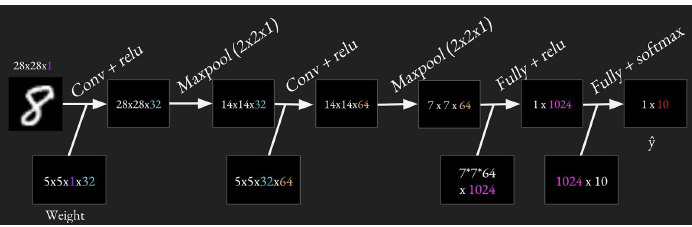

그 이유는 같은 작업을 몇번 할 것이기 때문입니다.(conv + relu twice, max pooling twice, fully connected twice) 이는 코드 재사용성에서 좋은 아이디어 입니다. 또한 variable scope를 사용함에 있어 중요합니다. 우리는 다른 계층에 같은 이름의 변수를 사용 할 수 있습니다. 변수 이름이 'weight'이며 variable scope'conv1' 안에 있다면 'conv1/weights'로 나타날 것입니다. 일반적인 연습에서 각각의 layer에서 variable scope를 만들어서 만약 convolution layer1과 layer2에서 weights의 변수를 가지고 있는 경우 name clash가 나지 않도록 해줍니다. 만약 variable scope에 대해 이해가 부족한 경우, Variable sharing 파트를 참조하십시오.

#### Convolution layer

우리는 'tf.nn.conv2d(tf.layer API)'를 convolution layer를 만들기 위해 사용할 것입니다. 일반적으로 convolution layer와 비선형성(non-linearity)를 함께 그룹화하며, 우리도 이러한 방식으로 진행 할 것입니다. 우리는 convolution layer에 사용할 수 있는 'conv_relu' method를 생성 할 것입니다.

In [ ]:
def conv_relu(inputs, filters, k_size, stride, padding, scope_name):
    with tf.variable_scope(scope_name, reuse=tf.AUTO_REUSE) as scope:
        in_channels = inputs.shape[-1]
        kernel = tf.get_variable('kernel', [k_size, k_size, in_channels, filters], 
                                initializer=tf.truncated_normal_initializer())
        biases = tf.get_variable('biases', [filters],
                            initializer=tf.random_normal_initializer())
        conv = tf.nn.conv2d(inputs, kernel, strides=[1, stride, stride, 1], padding=padding)
    return tf.nn.relu(conv + biases, name=scope.name)

우리는 출력의 차원 수(공간 크기)를 손으로 계산할 필요는 없지만, 각 단계에서 입력이 어떻게 변화하는지 알고 있는게 좋습니다. 우리는 각 차원에서 공간의 크기(width/depth)를 다음의 함수를 이용하여 계산할 수 있습니다.

    ● the input volume size (W)
    ● the receptive field size of filter (F)
    ● the stride with which they are applied (S)
    ● the amount of zero padding used (P) on the border.
    
    The formula is as followed:
            (W − F + 2P) / S + 1
            


예를 들어, 7x7 input과 3x3 필터, stride 1, pad 0로 설정하면 5x5의 결과를 얻을 것입니다. stride를 2로 설정하게 되면 3x3의 결과를 얻을 것 입니다. 이러한 경우에 첫번제 convolution layer에서

    ● input of size 28x28
    ● filter size 5x5
    ● stride 1x1
    ● padding (done automatically for us) 2
    So the spatial size of the output would be:
            (28 − 5 + 2 * 2) / 1 + 1 = 28

A nice illustration to see how striding affect the dimensionality of the outside. For full analysis, see

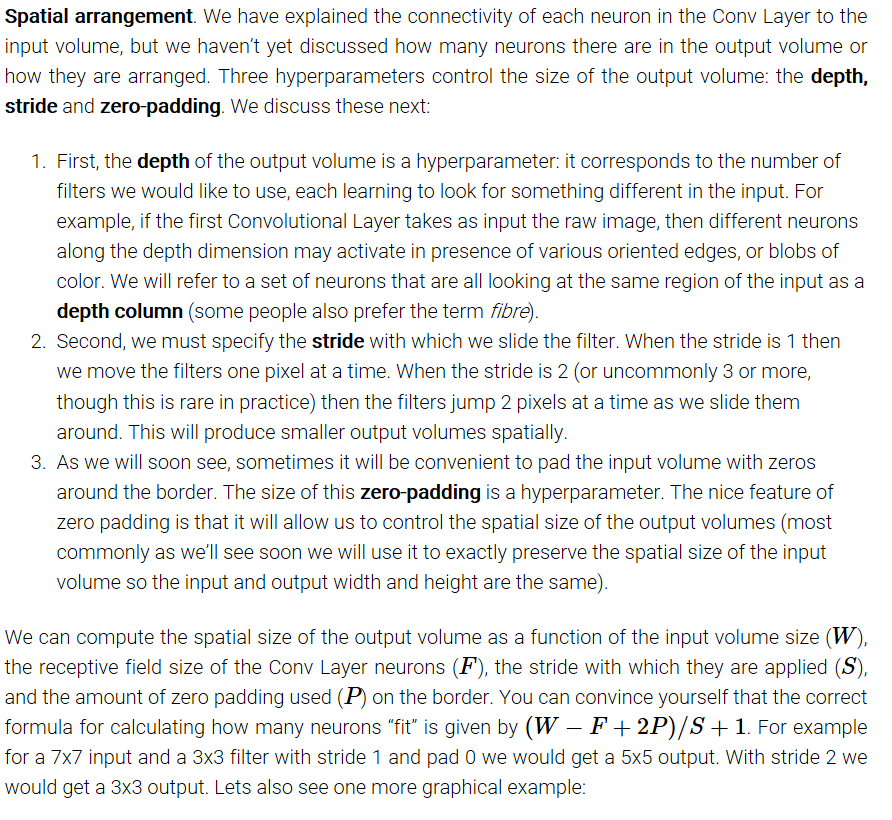

*패딩(padding)??

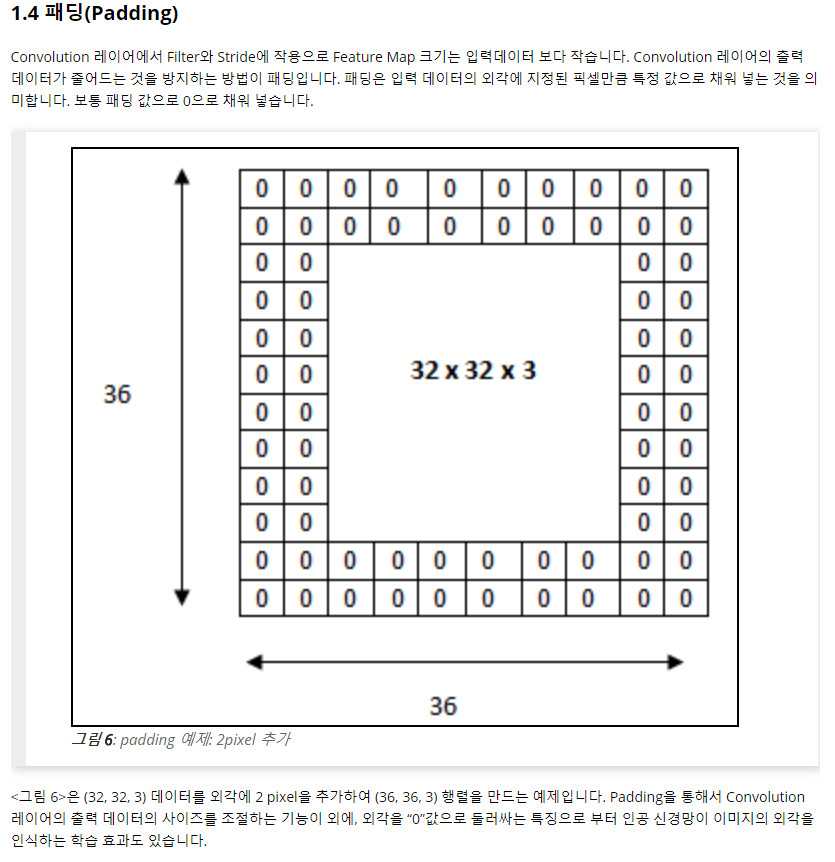
출처 : http://taewan.kim/post/cnn/

#### Pooling

Pooling은 downsampling의 하나로, 실행 속도를 줄이기 위해서 convoltion layer에서 feature map의 크기를 줄이는 기술입니다. Pooling layer는 데이터를 가장 잘 대표할 수 있는 부분(feature)의 영역으로 대체합니다. 가장 인기있는 pooling 알고리즘은 데이터의 최고 값의 영역으로 대체하는 'max pooling'입니다. 다른 알고리즘은 모든 값의 평균 값을 사용하는 'average pooling'이 있습니다.

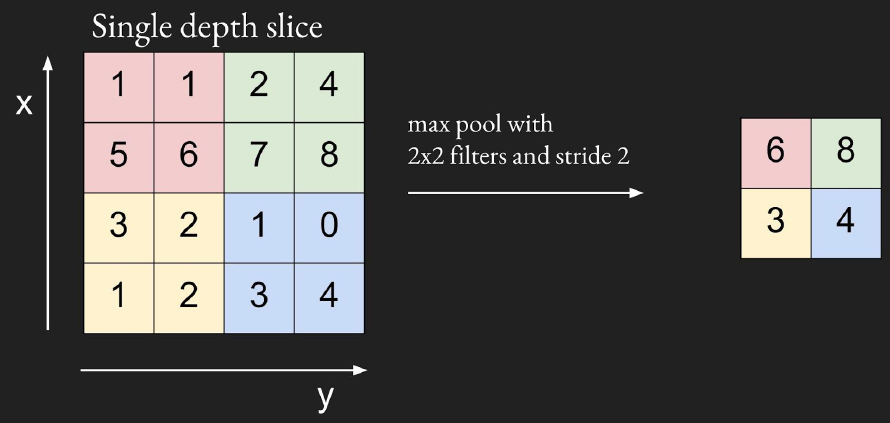

우리는 'tf.nn.max_pool'을 사용해서 max pooling layer를 만들 것입니다. 우리는 모든 pooling layer에서 사용하기 위해 maxpool 메소드를 만들 것입니다.

In [ ]:
def maxpool(inputs, ksize, stride, padding='VALID', scope_name='pool'):
    with tf.variable_scope(scope_name, reuse=tf.AUTO_REUSE) as scope:
        pool = tf.nn.max_pool(inputs, 
                            ksize=[1, ksize, ksize, 1], 
                            strides=[1, stride, stride, 1],
                            padding=padding)
    return pool

아래의 function을 사용하여 pooling layer output의 각 차원(width/depth)의 공간 크기를 계산 할 수 있습니다.

    ● the input volume size (W)
    ● the pooling size (K)
    ● the stride with which they are applied (S)
    ● the amount of zero padding used (P) on the border.
    The formula is as followed:
            (W − K + 2P) / S + 1
            
위의 경우에, 첫번째 max pooling layer에서
    ● input of size 28x28
    ● pooling size 2 x 2
    ● stride 2 x 2
    ● padding (done automatically for us) 0
    So the spatial size of the output would be:
            (28 − 2 + 2 * 0) / 2 + 1 = 14

#### Fully conneted

우리는 지금부터 fully conneted layer와 친해져야 합니다. 이는 모든 모델에 사용되고 있습니다. layer의 모든 node가 이전(preceding) layer의 모든 노드와 연결되기 때문에 Fully conntted(혹은 dense) layer라고 불리고 있습니다.

In [ ]:
def fully_connected(inputs, out_dim, scope_name='fc'):
    with tf.variable_scope(scope_name, reuse=tf.AUTO_REUSE) as scope:
        in_dim = inputs.shape[-1]
        w = tf.get_variable('weights', [in_dim, out_dim],
                            initializer=tf.truncated_normal_initializer())
        b = tf.get_variable('biases', [out_dim],
                            initializer=tf.constant_initializer(0.0))
        out = tf.matmul(inputs, w) + b
    return out

#### Putting it together

위의 blocks(layer)를 이용하여 우리는 쉽게 모델을 만들 수 있습니다.

In [ ]:
def inference(self):
        conv1 = conv_relu(inputs=self.img,
                        filters=32,
                        k_size=5,
                        stride=1,
                        padding='SAME',
                        scope_name='conv1')
        pool1 = maxpool(conv1, 2, 2, 'VALID', 'pool1')
        conv2 = conv_relu(inputs=pool1,
                        filters=64,
                        k_size=5,
                        stride=1,
                        padding='SAME',
                        scope_name='conv2')
        pool2 = maxpool(conv2, 2, 2, 'VALID', 'pool2')
        feature_dim = pool2.shape[1] * pool2.shape[2] * pool2.shape[3]
        pool2 = tf.reshape(pool2, [-1, feature_dim])
        fc = tf.nn.relu(fully_connected(pool2, 1024, 'fc'))
        dropout = tf.layers.dropout(fc, self.keep_prob, training=self.training, name='dropout')
        
        self.logits = fully_connected(dropout, self.n_classes, 'logits')

트레이닝 중에 우리는 training epoch와 acuracy 평가를 반복해서 출력할 수 있습니다. 우리는 Tensorboard에서 트레이닝 loss와 test accuracy 모두를 볼 것입니다.

In [ ]:
def eval(self):
        '''
        Count the number of right predictions in a batch
        '''
        with tf.name_scope('predict'):
            preds = tf.nn.softmax(self.logits)
            correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(self.label, 1))
            self.accuracy = tf.reduce_sum(tf.cast(correct_preds, tf.float32))

전체 코드는 class 깃허브의 07_convnet_mnist.py에서 볼 수 있습니다.

그래프가 이처럼 깔끔하게 나오도록 해보세요.

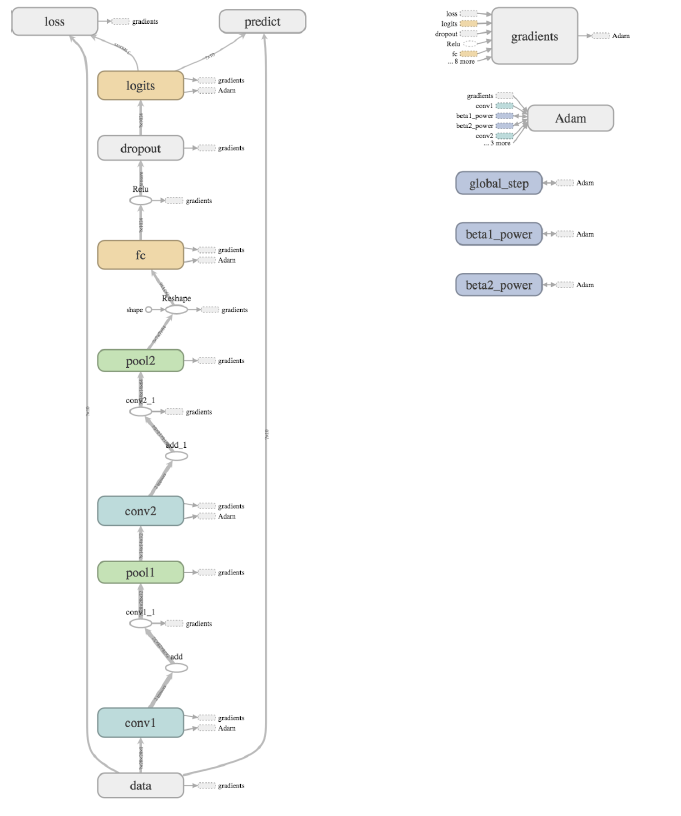

train loss가 감소할수록, 정확하게 예측한 숫자가 늘어나고 있습니다.

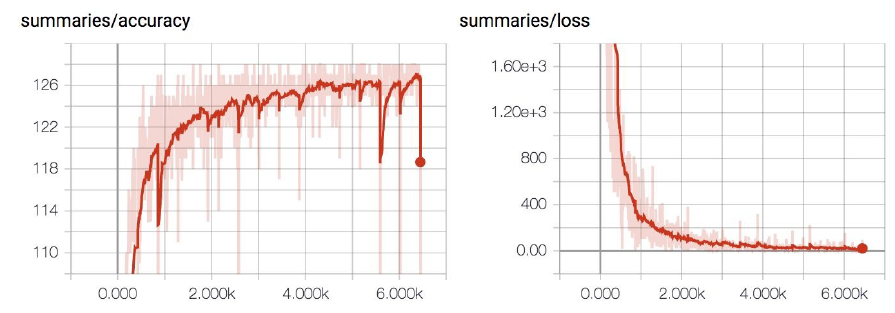

아래의 그림은 convolution neural network를 이용한 MNISt의 training 결과입니다.
우리는 좀 더 좋은 accuray를 얻을 수 있었지만, 대략 한 epoch에 250초의 더 많은 시간이 소요됩니다. 이는 각 step에서 많은 계산을 모델이 하기 때문인 것으로 추측됩니다.

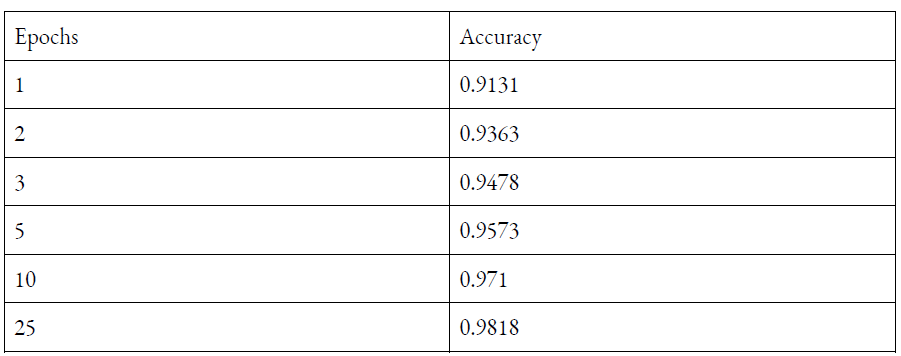

### tf.layers

우리는 지금 convnet을 어렵게 만드는 법을 배웠습니다. 우리는 사실 conv_relu method, pooling, fully_conntted 를 작성할 필요는 없습니다. Tensorflow는 many off-the-shelf layers를 'tf.layers' 를 통해 제공합니다. Keras, Sonnet처럼 higher level의 라이브러리도 몇 줄의 코드로 작성할 수 있는 미리 만들어진(ready-made) 모델을 제공하고 있습니다.

예를 들어, convolutional layer with relu non-linearity on the input image 를 만들기 위해서 아래 처럼 작성하면 됩니다. tf.layers.conv2d는 사용하고 싶은 acivation function을 선택할 수도 있습니다.

In [ ]:
conv1 = tf.layers.conv2d(inputs=self.img,
                                  filters=32,
                                  kernel_size=[5, 5],
                                  padding='SAME',
                                  activation=tf.nn.relu,
                                  name='conv1')

Max pooling과 fully connted layer는 다음과 같습니다.

In [ ]:
pool1 = tf.layers.max_pooling2d(inputs=conv1, 
                                        pool_size=[2, 2], 
                                        strides=2,
                                        name='pool1')

fc = tf.layers.dense(pool2, 1024, activation=tf.nn.relu, name='fc')

tf.layers를 사용하는 것은 꽤 간단 합니다. 조금 주의 할 것이 있다면, tf.layers.dropout에서 이 모델이 training mode인지, evaluation mode를 나타낼 수 있는 다른 변수(variable)이 필요합니다. 우리는 training에서 neurons을 drop out할 수 있으나, 이를 평가하는데도 사용할 수도 있기 떄문입니다.

In [ ]:
dropout = tf.layers.dropout(fc, 
                                    self.keep_prob, 
                                    training=self.training, 
                                    name='dropout')

tf.layers가 제공하는 전체 리스트를 보기 위해서는 공식 문서를 참고하시기 바랍니다.

https://www.tensorflow.org/tutorials/layers